In [1]:
import glob
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # resolution for figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [2]:
results_df = pd.read_excel('../data/Biosynth_Pipeline_validation.xlsx', 
                           sheet_name = 'Wenzhao Wu et. al. data')

In [3]:
num_molecules_synthesized_aft_PKSs = sum(results_df['PKS'].dropna())
num_molecules_synthesized_aft_Bio1 = sum(results_df['PKS-BIO1 (imt rules)'].dropna())
num_molecules_synthesized_aft_Bio2 = sum(results_df['PKS-BIO2 (imt rules)'].dropna())

In [4]:
print(f"Number of molecules that can be synthesized just by PKSs: {num_molecules_synthesized_aft_PKSs}")

Number of molecules that can be synthesized just by PKSs: 3.0


In [5]:
print(f"Number of molecules that can be synthesized by PKSs + 1 biology step: {num_molecules_synthesized_aft_Bio1}")

Number of molecules that can be synthesized by PKSs + 1 biology step: 49.0


In [6]:
print(f"Number of molecules that can be synthesized by PKSs + 2 biology steps: {num_molecules_synthesized_aft_Bio2}")

Number of molecules that can be synthesized by PKSs + 2 biology steps: 93.0


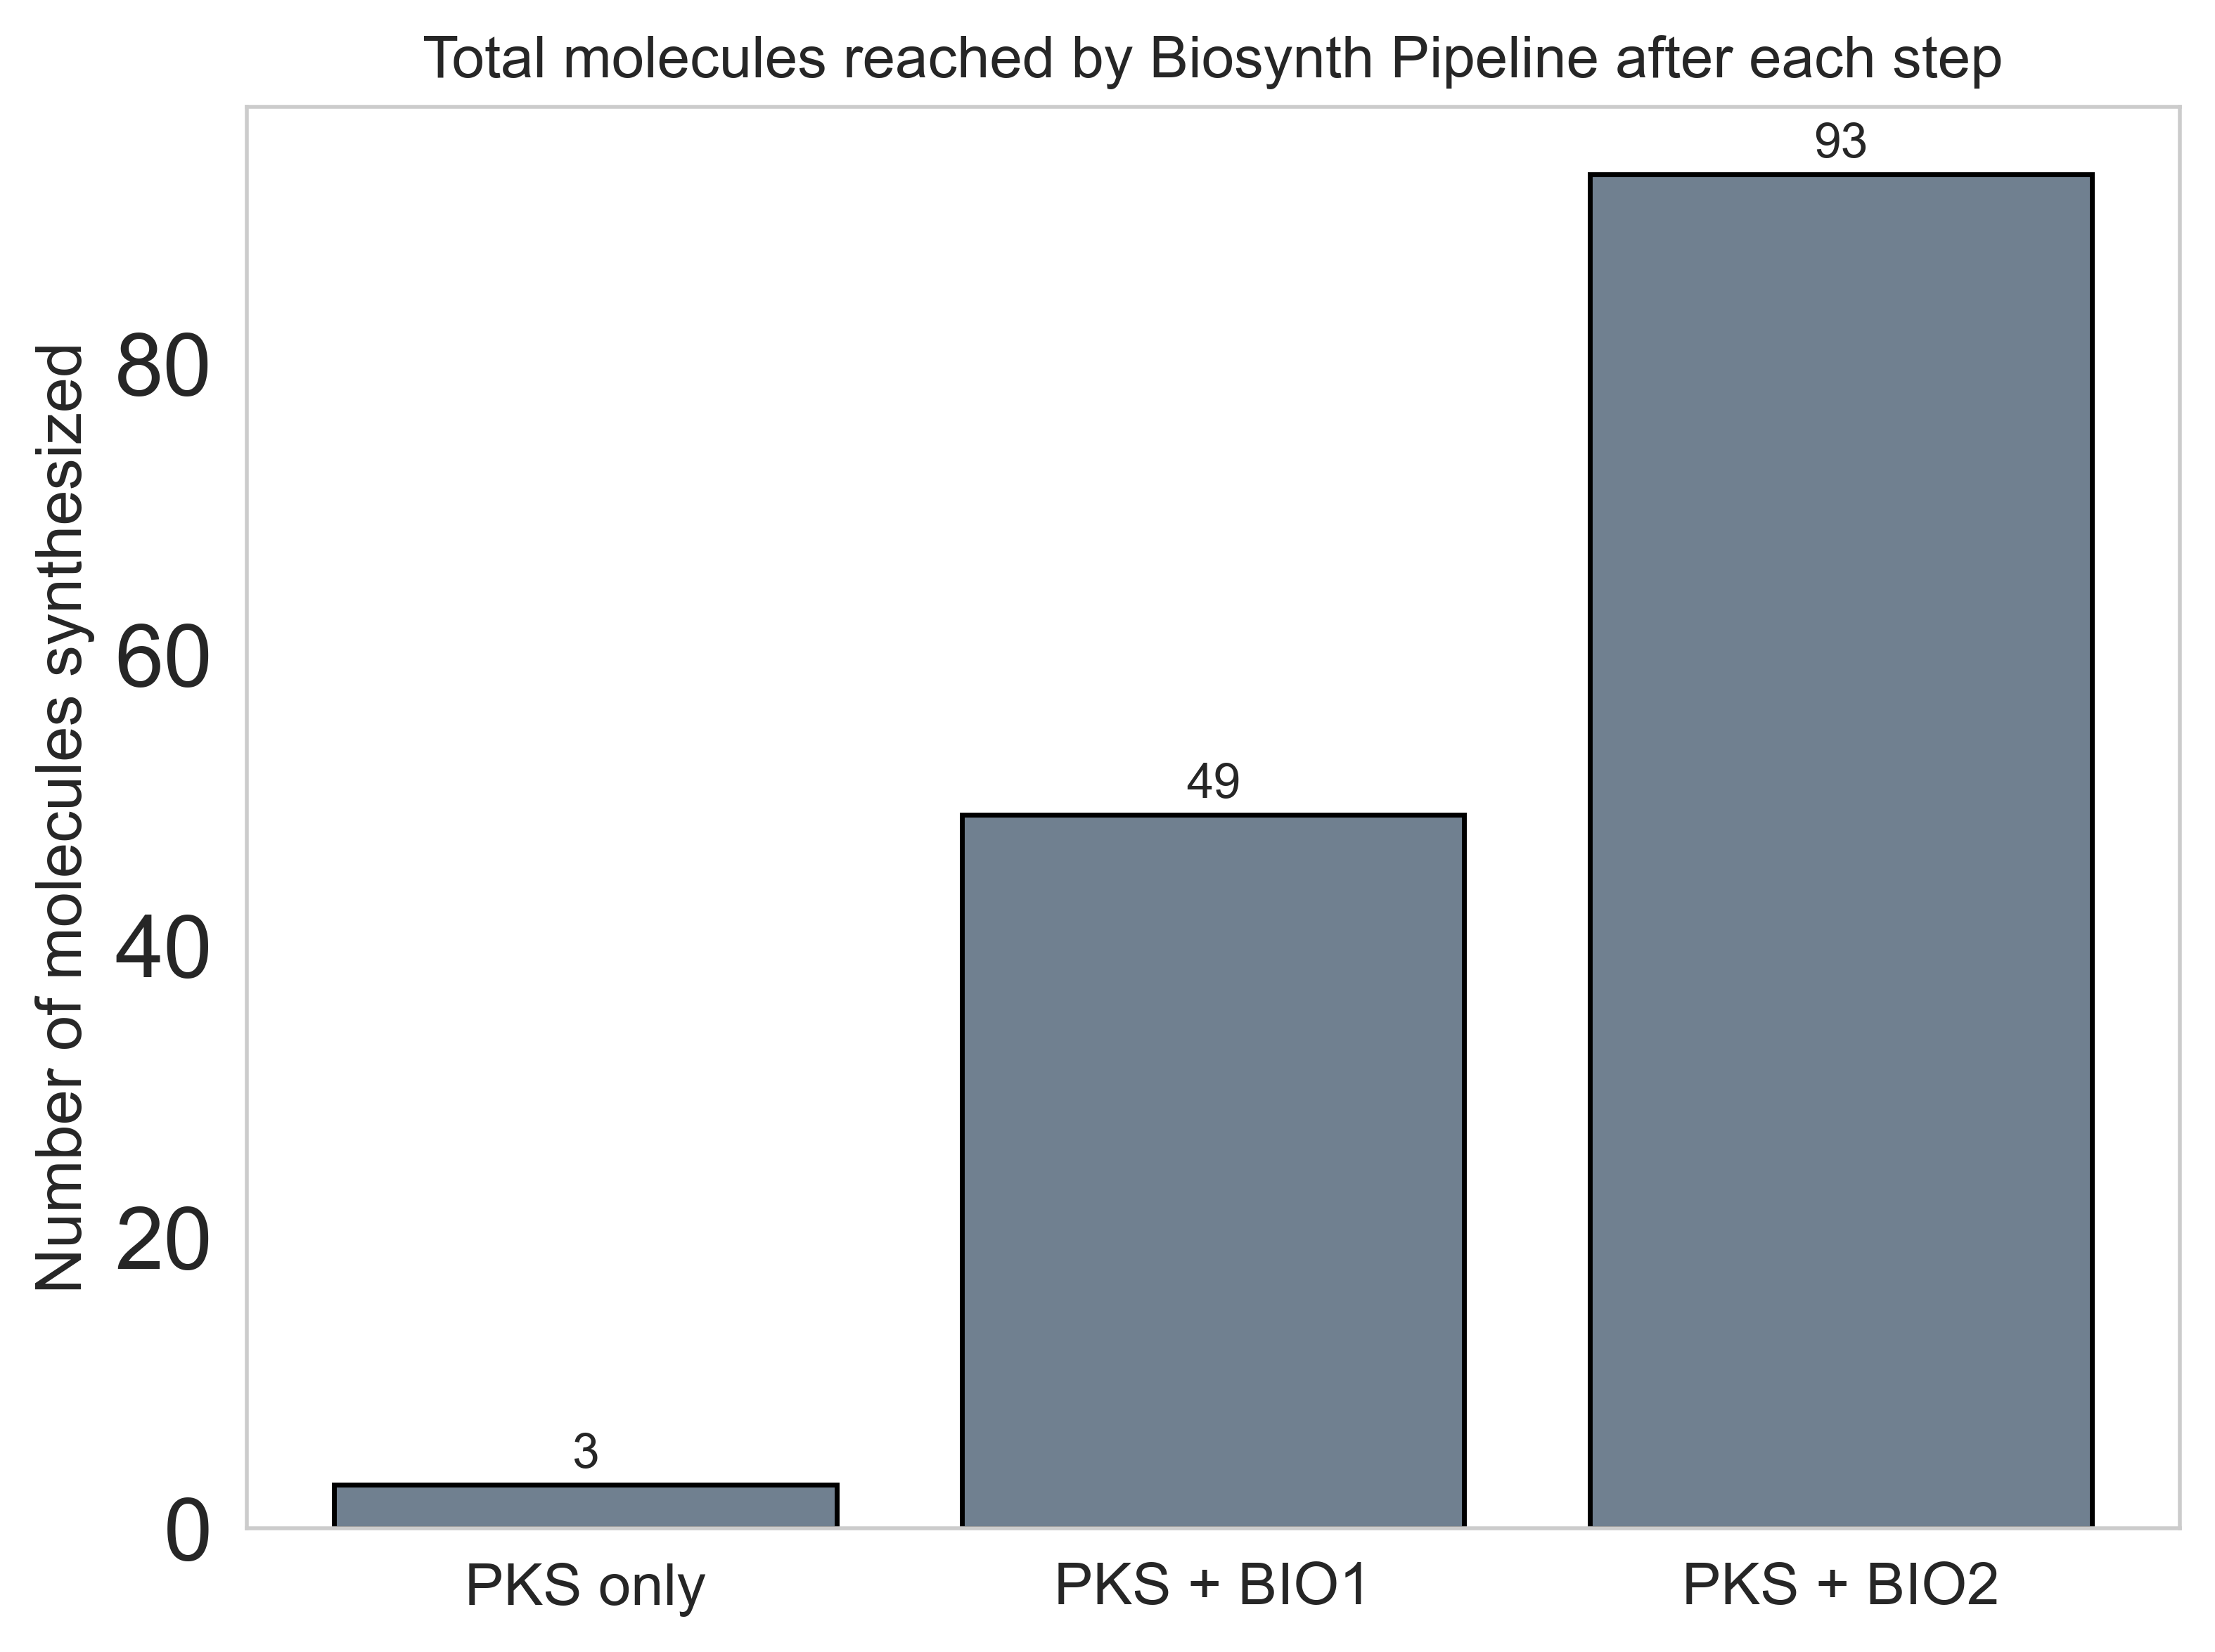

In [7]:
heights = [num_molecules_synthesized_aft_PKSs,
           num_molecules_synthesized_aft_Bio1, 
           num_molecules_synthesized_aft_Bio2]

labels = ['PKS only', 
          'PKS + BIO1', 
          'PKS + BIO2']

plt.bar(labels, heights, color= 'slategrey', edgecolor='k')  
plt.title('Total molecules reached by Biosynth Pipeline after each step')
plt.ylabel('Number of molecules synthesized',fontsize=13)
plt.xticks(fontsize=12)  

for i, height in enumerate(heights):
    plt.text(i, height + 0.5, str(int(height)), ha='center', va='bottom')  # Adjust text alignment and position

# Show the plot
plt.grid(False) # turn off grid
plt.savefig('../figures/fig7A_molecule_synthesis_with_biosynth_pipeline.png')
plt.show()

In [8]:
total_num_eligible = results_df[results_df['Used for validation?']=='Used for validation'].shape[0]

In [9]:
print(f"The total hit-rate of Biosynth Pipeline is: {num_molecules_synthesized_aft_Bio2/ total_num_eligible}")

The total hit-rate of Biosynth Pipeline is: 0.6


In [10]:
path = '../data/results_logs_for_manuscript_figs7A&B/*.txt'
txt_filepaths = glob.glob(path)

In [11]:
# initialize empty list to store the chemical similarities of the top product with respect to the target
PKS_product_similarities_list = []
BIO_1_product_similarities_list = []
BIO_2_product_similarities_list = []

for filepath in txt_filepaths:
    
    if 'PKS_BIO1' in filepath:
        with open(filepath,'r') as file:
            
            # initialize counters to track each PKS product and its corresponding bio product (1 step here)
            PKS_product_count = 0
            BIO_1_product_count = 0
            
            # then, parse through each line in this text file,
            for line in file:
                if 'PKS product similarity: ' in line:
                
                    # store the chemical similarity of the PKS product with respect to the target
                    PKS_product_similarities_list.append(float(line.strip('PKS product similarity :')))
                    PKS_product_count += 1 # update number of PKS products enumerated
                    
                if 'Bio product similarity: ' in line:
                
                    # store the chemical similarity of the post-PKS product with respect to the target
                    BIO_1_product_similarities_list.append(float(line.strip('Bio product similarity :')))
                    BIO_1_product_count += 1 # update number of post-PKS products enumerated
                
                # we only consider the top PKS design for this analysis so other PKS designs are not considered
                if PKS_product_count == 1 and BIO_1_product_count == 1:
                    break
        
    if 'PKS_BIO2' in filepath: 
        with open(filepath,'r') as file:
        
            # initialize counters to track each PKS product and its corresponding bio product (2 steps here)
            PKS_product_count = 0
            BIO_2_product_count = 0
            
            # then, parse through each line in this text file,
            for line in file:
                
                # for BIO2, we don't need to add the PKS product similarity again
                if 'PKS product similarity: ' in line:
                    PKS_product_count += 1 # update number of PKS products enumerated
                    
                if 'Bio product similarity: ' in line:
                
                    # store the chemical similarity of the post-PKS product with respect to the target
                    BIO_2_product_similarities_list.append(float(line.strip('Bio product similarity :')))
                    BIO_2_product_count += 1 # update number of post-PKS products enumerated
                
                # we only consider the top PKS design for this analysis so other PKS designs are not considered
                if PKS_product_count == 1 and BIO_2_product_count == 1:
                    break

In [12]:
assert len(PKS_product_similarities_list) == len(BIO_1_product_similarities_list)

In [13]:
non_synthesized_PKS_product_similarities_list = []
non_synthesized_BIO_1_product_similarities_list = []
non_synthesized_BIO_2_product_similarities_list = []

for i in range(len(PKS_product_similarities_list)):
    
    try:
        PKS_product_similarity = PKS_product_similarities_list[i]
        BIO_1_product_similarity = BIO_1_product_similarities_list[i]
        BIO_2_product_similarity = BIO_2_product_similarities_list[i]

    except IndexError:
        pass
    
    
    if PKS_product_similarity == 1 or BIO_1_product_similarity == 1 or BIO_2_product_similarity == 1:
        pass
    else:
        non_synthesized_PKS_product_similarities_list.append(PKS_product_similarity)
        non_synthesized_BIO_1_product_similarities_list.append(BIO_1_product_similarity)
        non_synthesized_BIO_2_product_similarities_list.append(BIO_2_product_similarity)

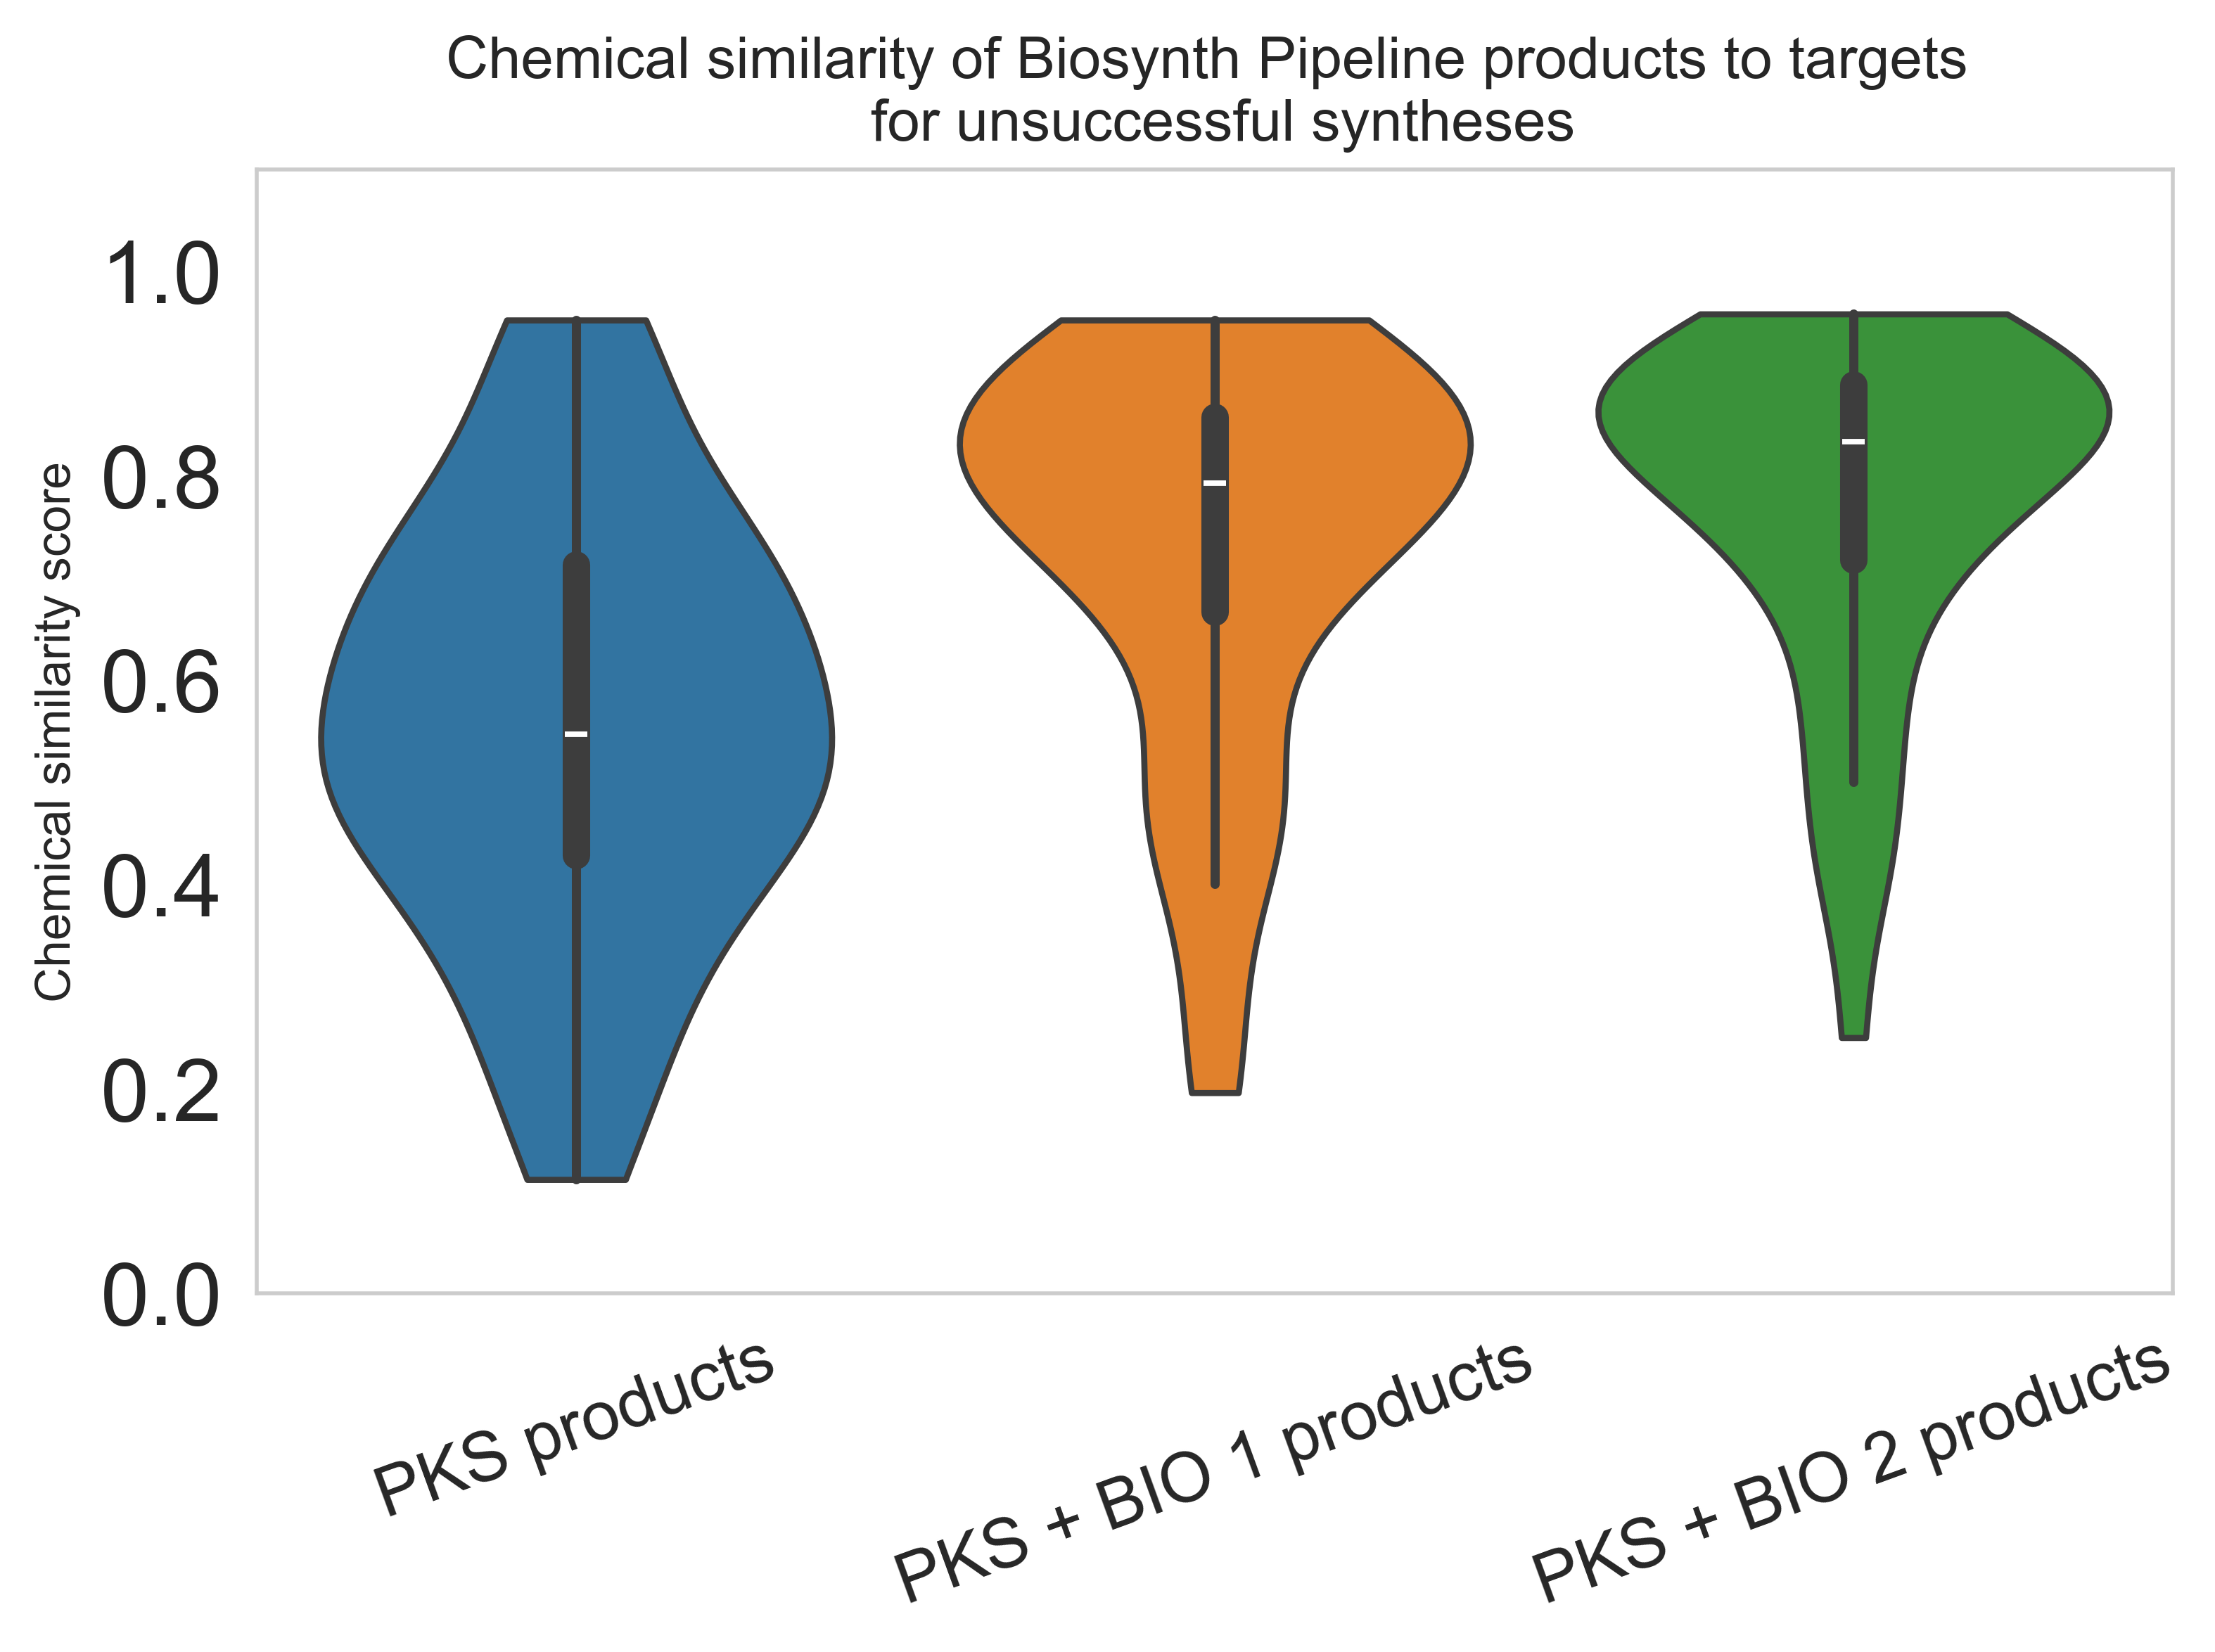

In [14]:
data = [non_synthesized_PKS_product_similarities_list, 
        non_synthesized_BIO_1_product_similarities_list,
        non_synthesized_BIO_2_product_similarities_list]

labels = ['PKS products', 
          'PKS + BIO 1 products', 
          'PKS + BIO 2 products']

# Create the violin plot
sns.violinplot(data = data, cut = 0)

# Adding titles and labels
plt.title('Chemical similarity of Biosynth Pipeline products to targets \n for unsuccessful syntheses')
plt.ylabel('Chemical similarity score')

# Set the x-tick labels to more meaningful names
plt.xticks(ticks=[0, 1, 2], labels = labels, fontsize = 14, rotation = 20)

# Show the plot
plt.grid(False) # turn off grid
plt.ylim([0,1.1])
plt.savefig('../figures/fig7B_similarity_violin_plot.png')
plt.show()

In [15]:
smiles_list = list(results_df['SMILES'].dropna())

In [16]:
data = {'SMILES': smiles_list} 

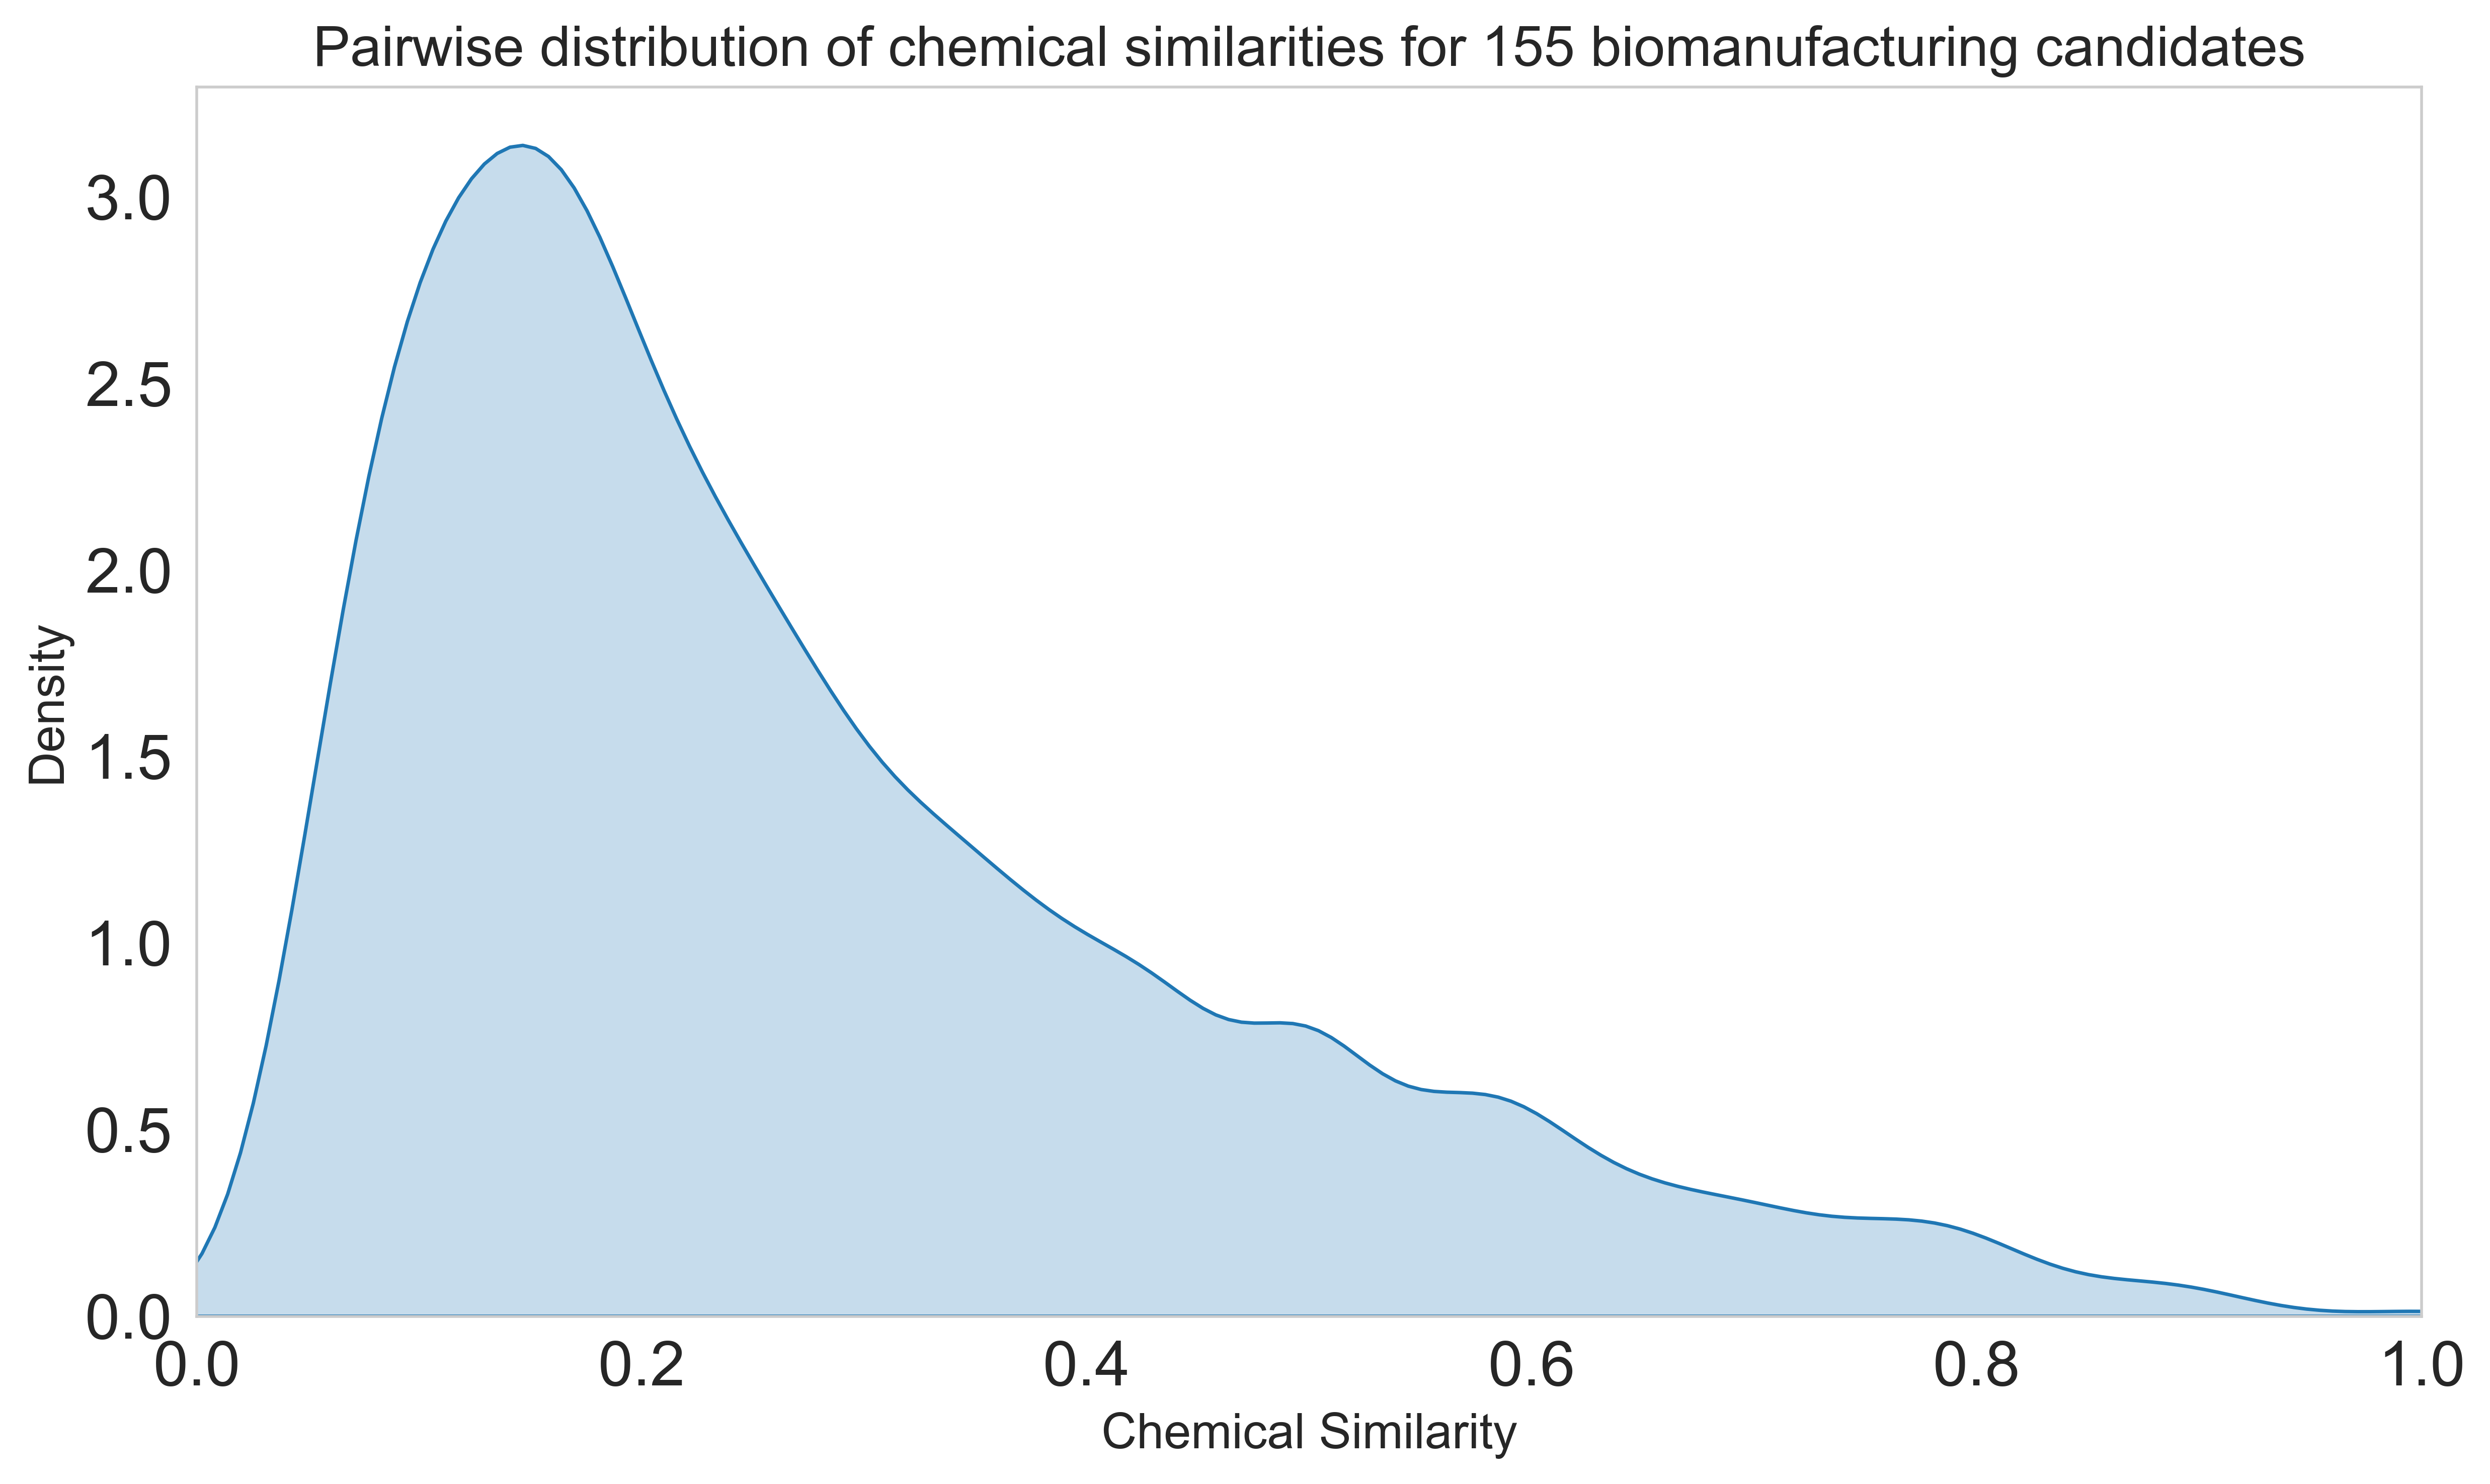

In [17]:
df = pd.DataFrame(data)
    
def calculate_chemical_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    result = rdFMCS.FindMCS([mol1, mol2],
                                    timeout = 1,
                                    matchValences = True,
                                    matchChiralTag = False, # don't pay attention to stereochemistry
                                    bondCompare = Chem.rdFMCS.BondCompare.CompareOrderExact)
    
    score = result.numAtoms / (len(mol1.GetAtoms()) + len(mol2.GetAtoms()) - result.numAtoms)
    
    return score

# Convert the RDKit fingerprints to a list
smiles_list = df['SMILES'].tolist()

# Calculate pairwise Tanimoto similarities
similarities = []
for i in range(len(smiles_list)):
    for j in range(i+1, len(smiles_list)):
        similarity = calculate_chemical_similarity(smiles_list[i], smiles_list[j])
        similarities.append(similarity)

# Create a DataFrame for the similarities
similarities_df = pd.DataFrame(similarities, columns=['Chemical Similarity'])

# Plot the KDE distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(similarities_df['Chemical Similarity'], shade=True)

plt.xlabel('Chemical Similarity', fontsize = 14)
plt.ylabel('Density', fontsize = 14)
plt.title('Pairwise distribution of chemical similarities for 155 biomanufacturing candidates',             fontsize = 16)

plt.grid(False) # turn off grid
plt.xlim([0,1])
plt.savefig('../figures/figSI_155_molecules_pairwise_sim_dist.png')
plt.show()